In [1]:
import cv2
from PIL import Image
# the previous import is to process my own images
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets

In [2]:
mean_gray = 0.1307
stddev_gray = 0.3081

# input[channel] = (input[channel]-meaan[channel]) / std[channel]

transforms_ori = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((mean_gray,),(stddev_gray,))])

train_dataset = datasets.MNIST(root='./data', 
                               train=True, 
                               transform=transforms_ori, 
                               download=True)

test_dataset = datasets.MNIST(root='./data', 
                               train=False, 
                               transform=transforms_ori)

# The next code is to transform the image
transforms_photo = transforms.Compose([transforms.Resize((28,28)),
                                      transforms.ToTensor(),
                                      transforms.Normalize((mean_gray,),(stddev_gray,))])


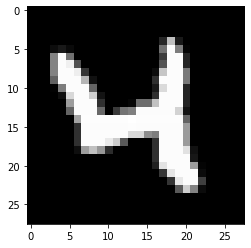

In [3]:
import matplotlib.pyplot as plt
random_img = train_dataset[20][0].numpy() * stddev_gray + mean_gray
plt.imshow(random_img.reshape(28,28), cmap='gray')

In [4]:
print(train_dataset[20][1])

4


In [5]:
batch_size = 100

train_load = torch.utils.data.DataLoader(dataset=train_dataset,
                                        batch_size=batch_size,
                                        shuffle=True)

test_load = torch.utils.data.DataLoader(dataset=test_dataset,
                                        batch_size=batch_size,
                                        shuffle=True)


In [6]:
len(test_load)

100

In [7]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        # Same padding means that input_size = output_size
        # same_padding = (filter_size - 1) / 2
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3,3), stride=1, padding=1)
        # The output from this layer has size:
        # [(input_size - filter_size + 2*(padding)) / stride] + 1
        self.batchnorm1 = nn.BatchNorm2d(8)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=(2,2))
        # Pooling output size is 28/2 = 14 (downsampling)
        # Same padding size is (5 - 1)/2 = 2
        self.cnn2 = nn.Conv2d(in_channels=8, out_channels=32, kernel_size=(5,5), stride=1, padding=2)
        self.batchnorm2 = nn.BatchNorm2d(32)
        # Pooling output size is 14/2 = 7 (downsampling)
        # We have to flatten the output channels 32*7*7 = 1568
        self.fc1 = nn.Linear(1568,600)
        self.dropout = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(600,10)
        
    def forward(self,x):
        out = self.cnn1(x)
        out = self.batchnorm1(out)
        out = self.relu(out)
        out = self.maxpool(out)
        out = self.cnn2(out)
        out = self.batchnorm2(out)
        out = self.relu(out)
        out = self.maxpool(out)
        # we have to flatten the 32 feature maps, output of our last maxpool (100, 1568)
        out = out.view(-1, 1568) # <- setting the number of rows to -1 is important, because 
        out = self.fc1(out)      #    when we try to predict we would require to use a size 100 (batch size)
        out = self.relu(out)     #    tensor but -1 infers the size.
        out = self.dropout(out)
        out = self.fc2(out)
        
        return out
        

In [8]:
model = CNN()

CUDA = torch.cuda.is_available()

if CUDA:
    model = model.cuda()
    
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)


In [9]:
print(CUDA)

True


In [10]:
# Understand what is happening
iteration = 0
correct = 0

for i,(inputs, labels) in enumerate(train_load):
    
    if CUDA:
        inputs = inputs.cuda()
        labels = labels.cuda()
        
    print('For one iteration this is what happens:')
    print('Input shape: ', inputs.shape)
    print('Labels shape: ', labels.shape)
    output = model(inputs)
    print('Output shape: ', output.shape)
    _, predicted = torch.max(output, dim=1)
    print('Predicted shape: ', inputs.shape)
    print('Predicted tensor: ')
    print(predicted)
    correct += (predicted==labels).sum()
    break
    

For one iteration this is what happens:
Input shape:  torch.Size([100, 1, 28, 28])
Labels shape:  torch.Size([100])
Output shape:  torch.Size([100, 10])
Predicted shape:  torch.Size([100, 1, 28, 28])
Predicted tensor: 
tensor([9, 4, 9, 4, 0, 7, 3, 7, 8, 4, 0, 0, 4, 9, 9, 8, 4, 0, 6, 4, 9, 0, 3, 8,
        8, 8, 0, 0, 8, 9, 3, 8, 4, 0, 4, 8, 9, 0, 4, 4, 0, 9, 0, 9, 9, 7, 4, 4,
        8, 0, 0, 8, 8, 0, 0, 4, 9, 9, 9, 4, 8, 4, 0, 4, 0, 8, 0, 0, 4, 8, 4, 4,
        7, 8, 5, 4, 8, 9, 9, 8, 7, 8, 0, 9, 0, 4, 0, 9, 9, 8, 5, 0, 4, 9, 4, 7,
        9, 4, 4, 9], device='cuda:0')


In [11]:
# Training of the CNN
num_epochs = 10
train_loss = list()
train_accuracy = list()
test_loss = list()
test_accuracy = list()


for epoch in range(num_epochs):
    correct = 0
    iterations = 0
    iter_loss = 0.0
    
    # When batch normalization and dropout are used
    # we have to specify our model that we are training
    model.train()
    
    for i,(inputs, labels) in enumerate(train_load):
        
        if CUDA:
            inputs = inputs.cuda()
            labels = labels.cuda()
        
        outputs = model(inputs)
        loss = loss_fn(outputs,labels)
        iter_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        _, predicted = torch.max(outputs, dim=1)
        correct += (predicted==labels).sum().item()
        iterations += 1
    
    train_loss.append(iter_loss/iterations)
    train_accuracy.append(correct/len(train_dataset))
    
    # Testing phase
    testing_loss = 0.0
    correct = 0
    iterations = 0
    
    model.eval()
    
    for i,(inputs, labels) in enumerate(test_load):
        
        if CUDA:
            inputs = inputs.cuda()
            labels = labels.cuda()
        
        outputs = model(inputs)
        loss = loss_fn(outputs,labels)
        testing_loss += loss.item()
        
        _, predicted = torch.max(outputs, dim=1)
        correct += (predicted==labels).sum().item()
        iterations += 1
    
    test_loss.append(iter_loss/iterations)
    test_accuracy.append(correct/len(test_dataset))
    
    print('Epoch {}/{}, Training loss: {:.3f}, Training accuracy: {:.3f}, Testing loss: {:.3f}, Testing accuracy: {:.3f}'.format(
    epoch+1,num_epochs,train_loss[-1],train_accuracy[-1],test_loss[-1],test_accuracy[-1]))


  

Epoch 1/10, Training loss: 0.574, Training accuracy: 0.840, Testing loss: 3.446, Testing accuracy: 0.974
Epoch 2/10, Training loss: 0.151, Training accuracy: 0.956, Testing loss: 0.907, Testing accuracy: 0.984
Epoch 3/10, Training loss: 0.105, Training accuracy: 0.971, Testing loss: 0.629, Testing accuracy: 0.987
Epoch 4/10, Training loss: 0.085, Training accuracy: 0.975, Testing loss: 0.511, Testing accuracy: 0.989
Epoch 5/10, Training loss: 0.080, Training accuracy: 0.978, Testing loss: 0.477, Testing accuracy: 0.988
Epoch 6/10, Training loss: 0.068, Training accuracy: 0.981, Testing loss: 0.407, Testing accuracy: 0.990
Epoch 7/10, Training loss: 0.064, Training accuracy: 0.982, Testing loss: 0.385, Testing accuracy: 0.990
Epoch 8/10, Training loss: 0.062, Training accuracy: 0.982, Testing loss: 0.369, Testing accuracy: 0.989
Epoch 9/10, Training loss: 0.058, Training accuracy: 0.983, Testing loss: 0.346, Testing accuracy: 0.986
Epoch 10/10, Training loss: 0.055, Training accuracy: 0

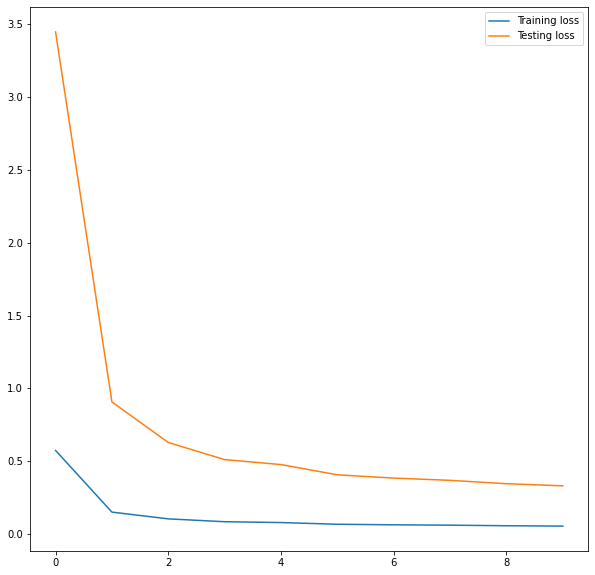

In [12]:
# Plotting the loss

f = plt.figure(figsize=(10,10))
plt.plot(train_loss, label='Training loss')
plt.plot(test_loss, label='Testing loss')
plt.legend()
plt.show()


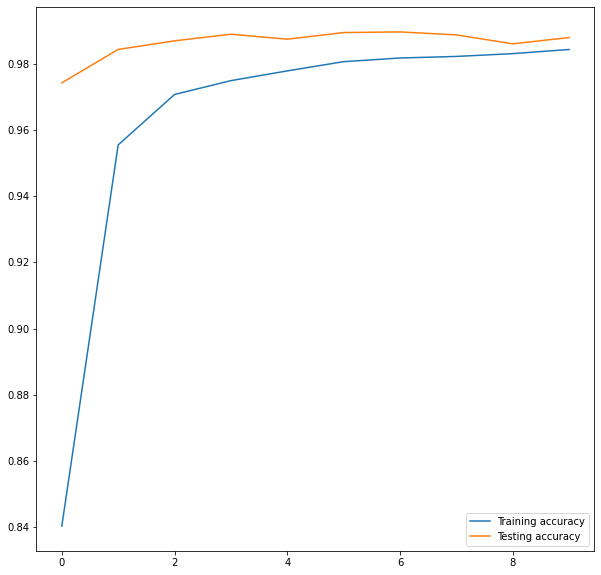

In [13]:
# Plotting the accuracy

f = plt.figure(figsize=(10,10))
plt.plot(train_accuracy, label='Training accuracy')
plt.plot(test_accuracy, label='Testing accuracy')
plt.legend()
plt.show()


In [14]:
img = test_dataset[31][0].resize_((1,1,28,28))
label = test_dataset[31][1]

model.eval()

if CUDA:
    model = model.cuda()
    img = img.cuda()
    
output = model(img)
_, predicted = torch.max(output, dim=1)
print('Prediction is: {}'.format(predicted.item()))
print('Actual label is: {}'.format(label))


Prediction is: 1
Actual label is: 1


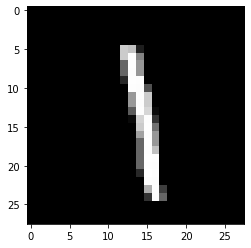

In [15]:
random_img = test_dataset[31][0].numpy() * stddev_gray + mean_gray
plt.imshow(random_img.reshape(28,28), cmap='gray')

In [21]:
def predict(img_name,model,show_image=False):
    image = cv2.imread(img_name,0)
    ret, thresholded = cv2.threshold(image,127,255,cv2.THRESH_BINARY)
    img = 255 - thresholded
    if show_image == True:
        cv2.imshow('Original',img)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
        
    img = Image.fromarray(img)
    img = transforms_photo(img)
    img = img.view(1,1,28,28)
    #img = Variable(img)
    
    model.eval()
    
    if CUDA:
        model = model.cuda()
        img = img.cuda()
        
    output = model(img)
    print(output)
    print(output.data)
    _, predicted = torch.max(output,1)
    return predicted.item()
    

In [22]:
pred = predict('photo.jpg',model)
print('the predicted label is {}'.format(pred))

tensor([[-5.4035,  2.6434,  8.6153, -3.0462, -7.2718, -7.2775, -1.7709,  0.8279,
         -4.8467, -8.3950]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[-5.4035,  2.6434,  8.6153, -3.0462, -7.2718, -7.2775, -1.7709,  0.8279,
         -4.8467, -8.3950]], device='cuda:0')
the predicted label is 2
